In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
seq_length = 7

In [3]:
# Q1. "데이터 불러오기 - "stock_daily.csv"을 불러오세요.

df = pd.read_csv("data/stock_daily.csv")

# Q2a. 데이터를 역순으로 정렬하고, 전체 데이터의 70% 학습, 30% 테스트에 사용하세요.
df = df[::-1]
df["Volume"] = df["Volume"].astype("float")


In [4]:
train_index = int(len(df) * 0.7)
train_index

512

In [5]:
train_df = df[:train_index]
train_df.tail()

,Open,High,Low,Volume,Close
224,738.599976,750.340027,737.000000,1576700.0,749.909973
223,750.059998,752.799988,742.429993,1134200.0,745.289978
222,738.000000,742.799988,735.369995,1132300.0,737.799988
221,735.770020,746.239990,735.559998,1053700.0,745.690002
220,745.369995,747.000000,736.280029,1453200.0,740.280029


In [6]:

# Q2b. 단, 테스트에 사용될 데이터에는 7일간의 데이터가 포함되지 않아야 합니다.
#-7의 의미: -7은 인덱스에서 끝에서 7번째 위치를 의미합니다. 즉, df의 끝에서 7개 데이터를 제외한다는 뜻입니다.
test_df = df[train_index:-seq_length]

In [7]:
test_df.head()

,Open,High,Low,Volume,Close
219,743.969971,745.450012,735.549988,1290800.0,739.150024
218,743.020020,745.000000,736.049988,1220100.0,736.099976
217,738.000000,743.830017,731.010010,1353000.0,743.090027
216,749.159973,754.380005,744.260986,1707100.0,751.719971
215,754.010010,757.309998,752.705017,1135300.0,753.200012


In [8]:
test_df.tail()

,Open,High,Low,Volume,Close
11,802.989990,806.000000,800.369995,1460400.0,801.489990
10,799.700012,801.669983,795.250000,1174200.0,801.340027
9,803.989990,810.500000,801.780029,1235200.0,806.969971
8,807.000000,811.840027,803.190002,1155300.0,808.380005
7,809.510010,810.659973,804.539978,989700.0,809.559998


###  MinMaxScaler()을 통해 train(특징x, 타겟y)과 test(특징x, 타겟y) 데이터를 0과 1사이의 값으로 바꾼다.

In [9]:
# Q3. MinMaxScaler를 사용해서 학습과 테스트 데이터를 전처리하세요.
# Q3a. 특징
scaler_x = MinMaxScaler()

#train_df 데이터프레임의 마지막 열을 제외한 모든 열을 의미합니다.
#즉, 마지막 열은 타겟 변수일 가능성이 높고, 이를 제외한 피쳐들만 스케일링합니다.
scaler_x.fit(train_df.iloc[:, :-1])

#transform 메서드는 fit 단계에서 학습한 최소값과 최대값을 사용하여 train_df의 피쳐를 스케일링합니다. 
#변환된 결과를 train_df의 원래 데이터프레임에 덮어씌웁니다.
train_df.iloc[:, :-1] = scaler_x.transform(train_df.iloc[:, :-1])
test_df.iloc[:, :-1] = scaler_x.transform(test_df.iloc[:, :-1])


# Q3b. 타겟-df[Close]
scaler_y = MinMaxScaler()
scaler_y.fit(train_df.iloc[:, [-1]])
train_df.iloc[:, -1] = scaler_y.transform(train_df.iloc[:, [-1]])
test_df.iloc[:, -1] = scaler_y.transform(test_df.iloc[:, [-1]])

In [10]:
test_df.tail()

,Open,High,Low,Volume,Close
11,1.063792,1.054884,1.119819,0.130187,1.087626
10,1.052441,1.040151,1.101490,0.104535,1.087098
9,1.067242,1.070196,1.124867,0.110003,1.106919
8,1.077627,1.074756,1.129914,0.102841,1.111883
7,1.086287,1.070740,1.134747,0.087999,1.116037


In [11]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch = 100

#time_series: 시계열 데이터가 저장된 Numpy 배열입니다. 각 행은 시점(time step)을 나타내며, 각 열은 특성(feature)을 나타냅니다.
#seq_length: 모델이 입력으로 사용할 시퀀스의 길이입니다. 즉, 모델이 예측을 하기 위해 사용하는 시점의 개수를 의미합니다.


#이 방식은 시계열 데이터에서 입력 시퀀스와 해당 시퀀스의 다음 시점의 값을 연결하여 예측 모델을 훈련하는 일반적인 방법입니다.
def build_dataset(time_series, seq_length):
    X_data = []
    Y_data = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i : i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]     
        X_data.append(_x)
        Y_data.append(_y)
    return np.array(X_data), np.array(Y_data)

In [12]:
np.array(train_df)
train_df.shape

(512, 5)

In [13]:
#for i in range(0, 505):
# _x   [0 : 7, :]~[504 :511, :]         0~6까지의 행의 모든 열
# _y   [7,[-1]]~[511,[-1]]               7행의 마지막 열
X_train, y_train = build_dataset(np.array(train_df), seq_length)

In [14]:
#7일을 제외했기에 220이 아닌 213이다.
np.array(test_df)
test_df.shape

(213, 5)

In [15]:
X_test, y_test = build_dataset(np.array(test_df), seq_length)

### build_dataset을 하고 난 뒤 train(특징x, 타겟y)과 test(특징x, 타겟y) 

In [16]:
print(X_train.shape,y_train.shape)

(505, 7, 5) (505, 1)


In [17]:
#(206, 7, 5)
#행의 수 (206)
#시퀀스 길이 (7):각 입력 시퀀스는 7개의 연속된 시점을 포함하고 있다는 뜻입니다. 
#특성의 수 (5)
X_test.shape

(206, 7, 5)

In [18]:
#행의 수 (206)
#타겟의 수 (1)
y_test.shape

(206, 1)

### 텐서로 변환

In [19]:

# Q4. 텐서로 변환하세요.
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


#훈련데이터로 만드는 데이터셋과 데이터로더

#훈련 데이터셋은 모델을 훈련시키는 데 사용됩니다.
dataset = TensorDataset(X_train_tensor, y_train_tensor)

#배치 단위로 데이터를 섞어서 모델을 학습
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True, drop_last=True)

In [20]:
import torch.nn as nn
import torch.optim as optim

# 설정값

#입력 시퀀스의 특성 수 (5개 특성)
data_dim = 5  

#LSTM의 숨겨진 상태(hidden state)의 차원 수 (10)
hidden_dim = 10

#모델의 출력 차원 (예: 예측할 값의 개수, 1)
output_dim = 1


learning_rate = 0.01
nb_epochs = 100


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers

        # Q5. 아래 두 레이어를 작성하세요.
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)



    #숨겨진 상태 (Hidden State): LSTM 네트워크의 현재 시점에서의 정보를 담고 있는 벡터입니다. 각 시점에서 LSTM의 출력이 이 벡터에 저장됩니다.
   #셀 상태 (Cell State): 장기적인 의존성을 유지하는 데 도움이 되는 벡터입니다. 셀 상태는 시퀀스 전체에 걸쳐 정보를 유지하며, 장기적인 기억을 담당합니다.
    #모델을 새롭게 학습할 때, 이전의 시퀀스에서의 상태가 현재 시퀀스에 영향을 미치지 않도록 하기 위해 숨겨진 상태와 셀 상태를 초기화합니다.
    #LSTM의 숨겨진 상태와 셀 상태를 초기화하는 방법
   #제로 초기화: 모든 값을 0으로 설정합니다. 이는 가장 일반적이고 직관적인 초기화 방법입니다.
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
            torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        )

    # Q6. forward 메서드를 작성하세요.
    #x는 LSTM의 출력
    #_는 LSTM의 숨겨진 상태(hidden state)와 셀 상태(cell state)입니다 (여기서는 사용하지 않음).
    # x[:, -1] :시퀀스의 마지막 시점에서의 출력을 추출합니다. 이 벡터는 LSTM 네트워크가 시퀀스의 마지막 시점에서 학습한 정보를 담고 있습니다.
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [21]:
# verbose=10: 훈련 과정의 로그를 출력하는 빈도.10 에폭마다 로그를 출력합니다.
#  patience=10: 조기 종료를 판단하기 위한 patience 값. 지정된 에폭 수 동안 개선이 없으면 조기 종료합니다.

def train_model(model, train_df, num_epochs=None, lr=None, verbose=10, patience=10):
    nb_epochs = num_epochs            # 훈련할 총 에폭 수를 설정합니다.
    train_hist = np.zeros(nb_epochs)  # 각 에폭에서의 평균 손실(loss)을 기록할 배열
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):           # 데이터로더에서 배치 단위로 데이터를 가져옵니다.
            x_train, y_train = samples                          # 입력 데이터와 레이블을 가져옵니다.
            model.reset_hidden_state()
            outputs = model(x_train)                             #모델을 통해 예측값을 계산
            loss = criterion(outputs, y_train)
            optimizer.zero_grad()                                #이전 배치에서 계산된 기울기를 초기화
            loss.backward()                                      #손실에 대한 기울기를 계산
            optimizer.step()                                    # 기울기를 사용하여 모델의 매개변수를 업데이트합니다.
            avg_cost += loss / total_batch                       #평균 손실을 업데이트
        train_hist[epoch] = avg_cost                             #에폭의 평균 손실,각 배치의 손실을 total_batch로 나누어 평균 손실을 누적하는 방식입니다.
        if epoch % verbose == 0:
            print("Epoch:", "%04d" % (epoch), "train loss :", "{:.4f}".format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            # loss가 커졌다면 early stop
            if train_hist[epoch - patience] < train_hist[epoch]:      #현재 에폭의 손실이 patience 이전 에폭의 손실보다 크면 조기 종료를 합니다.
                print("\n Early Stopping")
                break

    return model.eval(), train_hist       #모델을 평가 모드로 전환

In [22]:
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1)
model, train_hist = train_model(
    net, dataloader, num_epochs=nb_epochs, lr=learning_rate, verbose=20, patience=10
)

Epoch: 0000 train loss : 0.1308
Epoch: 0020 train loss : 0.0020
Epoch: 0040 train loss : 0.0017
Epoch: 0060 train loss : 0.0017

 Early Stopping


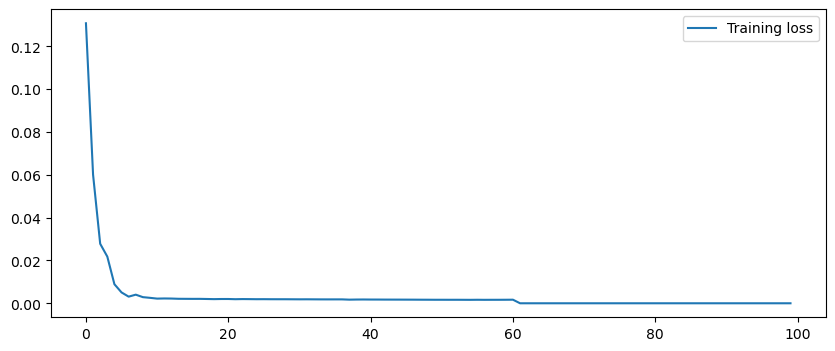

In [23]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

### 모델 저장
PATH = "stock_daily_.pth"에서 PATH에 지정된 경로는 현재 작업 디렉토리(working directory)에 상대적인 경로입니다. 파일 경로와 관련된 내용을 자세히 설명하겠습니다. <br />

예를 들어, 코드가 /home/user/projects 디렉토리에서 실행되고 있고, PATH = "stock_daily_.pth"로 지정하면, 파일은 /home/user/projects/stock_daily_.pth에 저장됩니다.

In [24]:
# 모델 저장
#PATH: 저장할 파일의 경로와 파일 이름을 나타냅니다. 여기서는 "stock_daily_.pth"라는 이름의 파일에 저장됩니다.
# .pth 확장자는 PyTorch 모델을 저장하는 데 사용되는 일반적인 파일 확장자입니다.
PATH = "stock_daily_.pth"

#torch.save: PyTorch에서 텐서나 모델의 상태를 파일에 저장하는 함수입니다.
#첫 번째 인자는 저장할 객체입니다.
#두 번째 인자는 저장할 경로와 파일 이름입니다.

#state_dict: PyTorch 모델의 모든 파라미터와 버퍼를 포함하는 딕셔너리입니다.
#모델의 모든 학습된 가중치(weight)와 편향(bias), 그리고 모델의 다른 상태 정보가 포함되어 있습니다.
torch.save(model.state_dict(), PATH)




In [25]:


# 불러오기
#1)모델 구조 정의
model = Net(data_dim, hidden_dim, seq_length, output_dim, 1)

#2)저장된 파라미터 로드
model.load_state_dict(torch.load(PATH), strict=False)

#3)모델을 평가 모드로 전환 (필요한 경우)
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_7836\2266513240.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH), strict=False)


Net(
  (lstm): LSTM(5, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

### PyTorch 모델을 사용하여 테스트 데이터셋에 대한 예측을 수행하고, 예측 결과를 원래 스케일로 되돌린 후, 실제 값과 예측 값 간의 평균 절대 오차(Mean Absolute Error, MAE)를 계산하는 과정입니다

#### 1) with torch.no_grad()::
이 블록 안에서는 그래디언트를 계산하지 않습니다. 이는 예측 모드에서 메모리 사용량과 연산 속도를 줄이는 데 유용합니다. 특히, 평가 또는 예측을 할 때는 그래디언트 계산이 필요 없으므로 효율적입니다.

In [27]:
X_test_tensor.shape

torch.Size([206, 7, 5])

#### 2)torch.unsqueeze(X_test_tensor[0], 0) <br />
torch.unsqueeze(input, dim): 주어진 차원 dim에 새로운 차원을 추가합니다.    <br />

input: 텐서  <br />
dim: 추가할 차원의 위치  <br /> 
X_test_tensor[0]: 첫 번째 샘플을 선택한 텐서로, 형태는 [7, 5]입니다.  <br />

torch.unsqueeze(X_test_tensor[0], 0):  <br />

dim=0에 새로운 차원을 추가합니다.  <br />
결과적으로 텐서의 형태가 [1, 7, 5]로 변환됩니다.  <br /> 
이는 첫 번째 차원이 배치 차원이 되며, batch_size=1로 설정된 것입니다. <br />

#### 3)torch.flatten(input): 입력 텐서를 1차원으로 평탄화합니다.
입력: predicted 텐서, 예를 들어 형태가 [1, 1]인 경우.
출력: 모든 차원을 평탄화하여 1차원 텐서를 생성합니다. 따라서 [1, 1] 형태의 텐서는 [1] 형태로 변환됩니다.

#### 4) .item()
item(): 텐서가 단일 값(스칼라)일 때, 이 값을 파이썬 숫자로 변환합니다.
텐서가 하나의 값만 포함하고 있을 때, 이 값을 Python의 기본 데이터 타입으로 변환합니다. 일반적으로 float, int 등이 될 수 있습니다.

#### 5)   pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
np.array(pred): pred 리스트를 NumPy 배열로 변환합니다. pred는 모델의 예측 결과를 담고 있는 리스트입니다. <br /> <br />
.reshape(-1, 1): 배열의 형태를 (n, 1)로 변환합니다. 여기서 -1은 NumPy가 자동으로 크기를 결정하도록 하는 특수한 값입니다.<br /> 
이 단계는 scaler_y.inverse_transform 메서드가 2D 배열을 요구하기 때문에 필요합니다. 모델 예측값이 1차원 배열이므로, 이를 2차원 배열로 변환합니다.<br /><br />
scaler_y.inverse_transform(...): scaler_y: 예측값을 스케일링할 때 사용한 스케일러입니다. MinMaxScaler <br />
inverse_transform: 스케일링된 데이터를 원래의 스케일로 변환합니다. <br /><br />
np.array(pred).reshape(-1, 1)은 모델의 예측값이 스케일링된 상태이므로, 이를 원래의 값으로 복원합니다.<br />

### 6) Mean Absolute Error (평균 절대 오차)를 계산하는 함수
매개변수 <br />
true: 실제 값(ground truth) 배열입니다. 실제 관측값이나 정답 데이터입니다.  <br />
pred: 모델의 예측값 배열입니다. 모델이 예측한 값들입니다.  <br />
 <br />
 
함수의 동작 <br />
true - pred: 실제 값과 예측 값의 차이를 계산합니다. 이 차이는 오차(오차)입니다. 각 데이터 포인트에서 예측 값이 실제 값과 얼마나 다른지를 나타냅니다.  <br />
np.abs(true - pred):
계산된 오차의 절대값을 구합니다. 절대값을 취하는 이유는 오차의 부호를 무시하고 크기만을 중요시하기 때문입니다. 예를 들어, 예측값이 실제값보다 클 수도 있고 작을 수도 있으므로 절대값을 사용하여 모든 오차를 양수로 변환합니다. <br />
np.mean(np.abs(true - pred)):
절대 오차의 평균을 계산합니다. 이는 평균 절대 오차(MAE)를 구하는 과정입니다. MAE는 전체 오차의 평균을 계산하여 모델의 예측 성능을 평가하는 지표입니다.

In [28]:
# 예측 테스트 (test 데이터를 이용)
with torch.no_grad():
    pred = []                                              # 예측 값을 저장할 빈 리스트를 초기화
    for pr in range(len(X_test_tensor)):

        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(X_test_tensor[pr], 0))
        predicted = torch.flatten(predicted).item()         #예측값을 1차원으로 변환하고, 파이썬 숫자(float)로 변환합니다.
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler_y.inverse_transform(np.array(pred).reshape(-1, 1))
    y_test_inverse = scaler_y.inverse_transform(y_test_tensor)                             # y_test_tensor.shape 은  [206,1] 2D 형태이기 때문에: 이미 올바른 형태로 되어 있어, 스케일러의 inverse_transform을 직접 적용하여 원래 스케일로 변환할 수 있습니다.


def MAE(true, pred):
    return np.mean(np.abs(true - pred))


print("MAE SCORE : ", MAE( y_test_inverse,pred_inverse))

MAE SCORE :  7.360441920782076
